In [1]:
import pandas as pd
from collections import Counter

# Data Preparation and visualization
import seaborn as sns
from matplotlib import pyplot as plt
from imblearn.under_sampling import RandomUnderSampler  
from sklearn.preprocessing import StandardScaler   
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from pylab import rcParams

# Model Selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, f1_score, auc, confusion_matrix

# Model Training
from sklearn import metrics   
from sklearn.model_selection import GridSearchCV


# Expand the size of terminal window to display all rows
pd.set_option('display.max_columns', 500) 

# Load Data

In [2]:
data = pd.read_csv('train_sample.csv')

In [3]:
## check data
print("train -  rows:",data.shape[0]," columns:", data.shape[1])

train -  rows: 100000  columns: 7


In [4]:
data.head()

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,11/7/2017 9:30,0
1,105560,25,1,17,259,11/7/2017 13:40,0
2,101424,12,1,19,212,11/7/2017 18:05,0
3,94584,13,1,13,477,11/7/2017 4:58,0
4,68413,12,1,1,178,11/9/2017 9:00,0


The trainset columns are:
* **ip**: ip address of click (numeric);

* **app**: app id for marketing (category);

* **device**: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.) (category);

* **os**: os version id of user mobile phone (category);

* **channel**: channel id of mobile ad publisher (category);

* **click_time**: timestamp of click (UTC) (time);

* **is_attributed**: the target that is to be predicted, indicating the app was downloaded (binary);

# Check for missing data and data balance

In [5]:
## check for missing data
data.isnull().sum()

ip               0
app              0
device           0
os               0
channel          0
click_time       0
is_attributed    0
dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


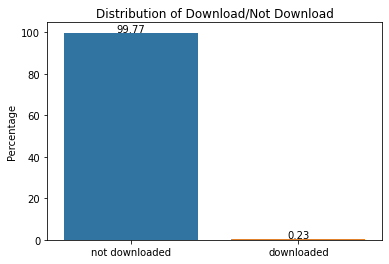

In [6]:
## check for data balance
pct = (data.is_attributed.values == 0).mean()

plot = sns.barplot(['not downloaded','downloaded'],[pct*100, (1-pct)*100])
plot.set(ylabel = 'Percentage')
plt.title("Distribution of Download/Not Download") 

for i in range(2):
    a = plot.patches[i]
    height = a.get_height()
    value = abs(pct - i)
    plot.text(a.get_x() + a.get_width()/2., height + 0.5, round(value * 100, 2), ha = "center")

We can see that the dataset is highly imbalanced, with 99.77% of session ended up with not downloading the app.

In [7]:
## Split the dataset based on whether the user has download the app. "1" as "download" and "0" as "not dowload"
t1 = data.loc[data['is_attributed'] == 1]
t0 = data.loc[data['is_attributed'] == 0]

<Figure size 432x288 with 0 Axes>

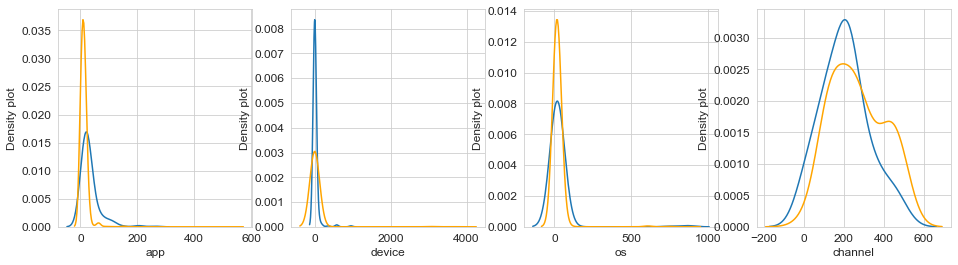

In [8]:
import matplotlib.patches as mpatches
####### check ######
var = ['app','device','os','channel']

i = 0

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(1,4,figsize=(16,4))

for feature in var:
    i += 1
    plt.subplot(1,4,i)
    sns.kdeplot(t1[feature], bw_method=0.5)
    sns.kdeplot(t0[feature], bw_method=0.5, color = 'Orange')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

# Manipulate Time Data

Manipulate time data, observe click and download trends.

In [9]:
# break the click_time into different dimensions
data['click_time'] = pd.to_datetime(data.click_time)
data['click_year'] = pd.to_datetime(data.click_time).dt.year
data['click_month'] = pd.to_datetime(data.click_time).dt.month
data['click_day'] = pd.to_datetime(data.click_time).dt.day
data['click_hour'] = pd.to_datetime(data.click_time).dt.hour
data['click_min'] = pd.to_datetime(data.click_time).dt.minute
data['click_sec'] = pd.to_datetime(data.click_time).dt.second
data.head()

,ip,app,device,os,channel,click_time,is_attributed,click_year,click_month,click_day,click_hour,click_min,click_sec
0,87540,12,1,13,497,2017-11-07 09:30:00,0,2017,11,7,9,30,0
1,105560,25,1,17,259,2017-11-07 13:40:00,0,2017,11,7,13,40,0
2,101424,12,1,19,212,2017-11-07 18:05:00,0,2017,11,7,18,5,0
3,94584,13,1,13,477,2017-11-07 04:58:00,0,2017,11,7,4,58,0
4,68413,12,1,1,178,2017-11-09 09:00:00,0,2017,11,9,9,0,0


<Figure size 432x288 with 0 Axes>

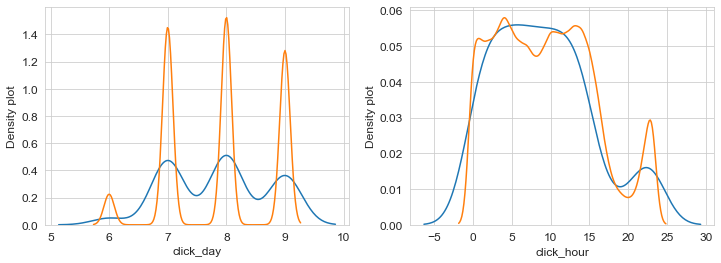

In [10]:
var = ['click_day','click_hour']

i = 0
t1 = data.loc[data['is_attributed'] == 1]
t0 = data.loc[data['is_attributed'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(12,4))

for feature in var:
    i += 1
    plt.subplot(1,2,i)
    sns.kdeplot(t1[feature])
    sns.kdeplot(t0[feature])
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

<ipython-input-11-5c24706c8b72>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t0['rounded_click'] = t0['click_time'].dt.round('H')


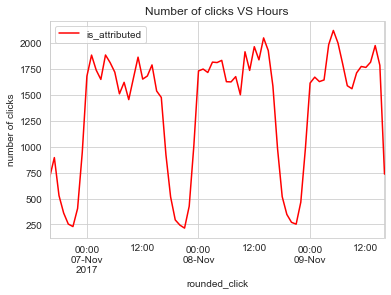

In [11]:
t0['rounded_click'] = t0['click_time'].dt.round('H')
t0[['rounded_click','is_attributed']].groupby('rounded_click',as_index = True).count().plot(color = 'r')
plt.ylabel('number of clicks')
plt.title('Number of clicks VS Hours')
plot.grid()

<ipython-input-12-83828cb05f10>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1['rounded_click'] = t1['click_time'].dt.round('H')


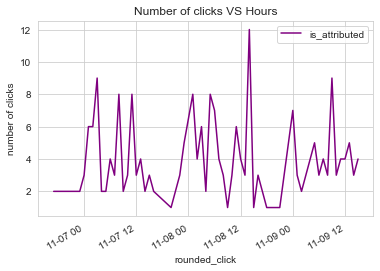

In [12]:
t1['rounded_click'] = t1['click_time'].dt.round('H')
t1[['rounded_click','is_attributed']].groupby('rounded_click',as_index = True).count().plot(color = 'purple')
plt.ylabel('number of clicks')
plt.title('Number of clicks VS Hours')
plot.grid()

## Create new features

In [13]:
GROUP_BY_NEXT_CLICKS = [
    
    # V1
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'channel']},
    {'groupby': ['ip', 'os']},
    
    # V3
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    {'groupby': ['ip', 'os', 'device']},
    {'groupby': ['ip', 'os', 'device', 'app']}
]

# Calculate the time to next click for each group
for spec in GROUP_BY_NEXT_CLICKS:
    
    # Name of new feature
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))    
    
    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']
    
    # Run calculation
    print(f">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}")
    data[new_feature] = data[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    
data.head()


>> Grouping by ['ip'], and saving time to next click in: ip_nextClick
>> Grouping by ['ip', 'app'], and saving time to next click in: ip_app_nextClick
>> Grouping by ['ip', 'channel'], and saving time to next click in: ip_channel_nextClick
>> Grouping by ['ip', 'os'], and saving time to next click in: ip_os_nextClick
>> Grouping by ['ip', 'app', 'device', 'os', 'channel'], and saving time to next click in: ip_app_device_os_channel_nextClick
>> Grouping by ['ip', 'os', 'device'], and saving time to next click in: ip_os_device_nextClick
>> Grouping by ['ip', 'os', 'device', 'app'], and saving time to next click in: ip_os_device_app_nextClick


,ip,app,device,os,channel,click_time,is_attributed,click_year,click_month,click_day,click_hour,click_min,click_sec,ip_nextClick,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick
0,87540,12,1,13,497,2017-11-07 09:30:00,0,2017,11,7,9,30,0,61560.0,61560.0,NaN,61560.0,NaN,61560.0,61560.0
1,105560,25,1,17,259,2017-11-07 13:40:00,0,2017,11,7,13,40,0,12720.0,8880.0,83760.0,4860.0,NaN,4860.0,NaN
2,101424,12,1,19,212,2017-11-07 18:05:00,0,2017,11,7,18,5,0,57960.0,NaN,NaN,57960.0,NaN,57960.0,NaN
3,94584,13,1,13,477,2017-11-07 04:58:00,0,2017,11,7,4,58,0,19560.0,NaN,NaN,NaN,NaN,NaN,NaN
4,68413,12,1,1,178,2017-11-09 09:00:00,0,2017,11,9,9,0,0,51060.0,53340.0,NaN,NaN,NaN,NaN,NaN


In [14]:
Y = data['is_attributed']

In [15]:
Counter(Y)

Counter({0: 99773, 1: 227})

In [16]:
X = data.drop(['is_attributed','click_time'], axis = 1).fillna(0)

# Train Test Split

In [17]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
x, y = pipeline.fit_resample(X,Y)
counter = Counter(y)
print(counter)

Counter({0: 19954, 1: 9977})


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [19]:
# Feature Scaling
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Dimensionality Reduction - PCA
pca = PCA(.95)   # Choose minimum number of principal components such that 95% of the variance is retained
X_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

pca.n_components_

12

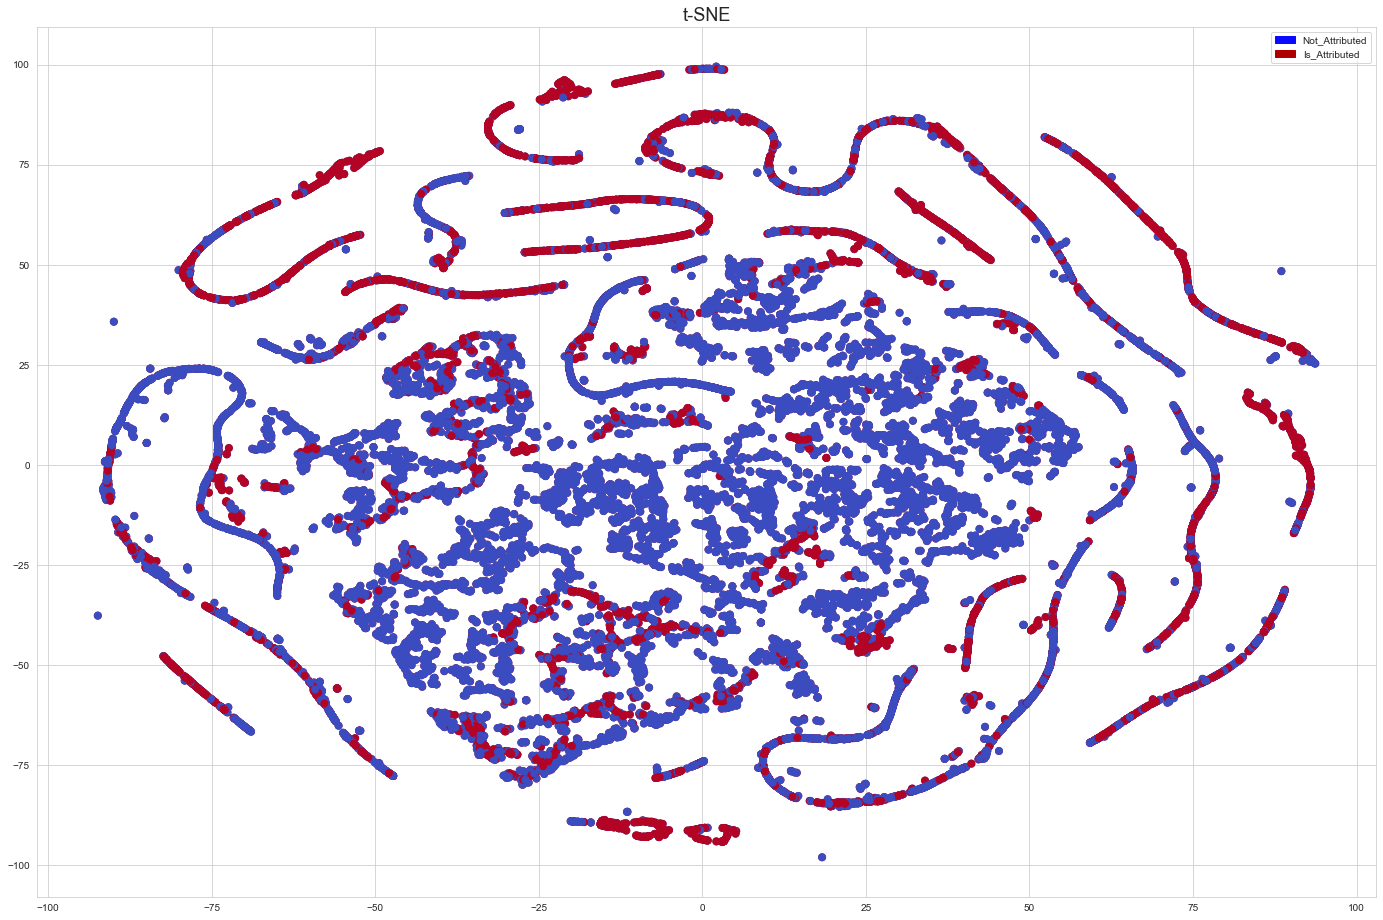

In [20]:
## t-SNE

X_reduced_tsne = TSNE(n_components = 2, random_state = 0).fit_transform(X_train)

f, ax = plt.subplots(figsize = (24,16))

blue_patch = mpatches.Patch(color = '#0A0AFF', label = 'Not_Attributed')
red_patch = mpatches.Patch(color = '#AF0000', label = 'Is_Attributed')

ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c = (y_train == 0), cmap = 'coolwarm', label = 'Not_Attributed', linewidths = 2)
ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c = (y_train == 1), cmap = 'coolwarm', label = 'Is_Attributed', linewidths = 2)
ax.set_title('t-SNE', fontsize = 18)

ax.grid(True)

ax.legend(handles = [blue_patch, red_patch])

# Model

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LR: 0.795583 (0.013298)
LDA: 0.877669 (0.009789)
KNN: 0.917974 (0.004856)
CART: 0.976294 (0.002914)
SVM: 0.811889 (0.008976)
RF: 0.999384 (0.000121)


<ipython-input-21-fdb3e51e4d64>:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


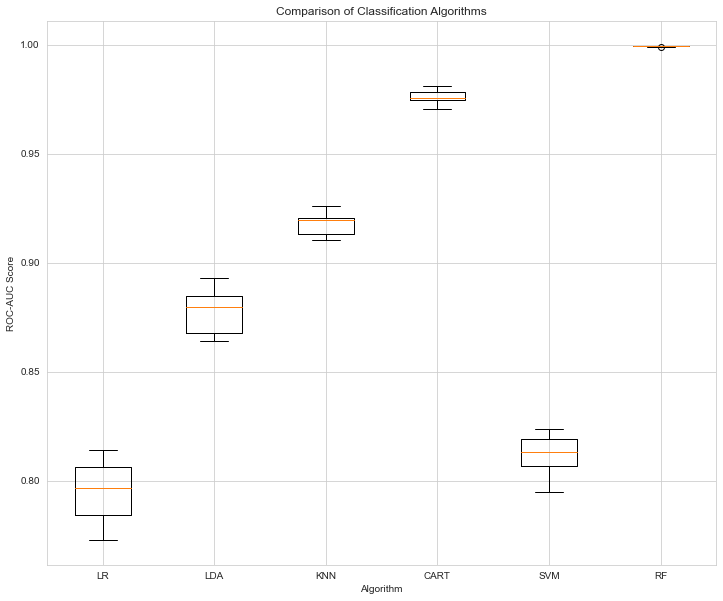

In [21]:
# Model Selection

## spot-checking algorithms

models = []

models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

# testing models

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits = 10, random_state = 42, shuffle = True)
    if name == ['LR', 'LDA']:
        cv_results = cross_val_score(model, X_pca, y_train, cv = kfold, scoring = 'roc_auc')
    elif name == ['KNN', 'SVM']:
        cv_results = cross_val_score(model, X_scaled, y_train, cv = kfold, scoring = 'roc_auc')
    else:
        cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)
    

# comparing algorithms 

fig = plt.figure(figsize = (12,10))
plt.title('Comparison of Classification Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('ROC-AUC Score')
plt.boxplot(results)
ax = fig.add_subplot(111)
ax.set_xticklabels(names)
plt.show()

# LogisticRegression

[[5282  716]
 [ 917 2065]]


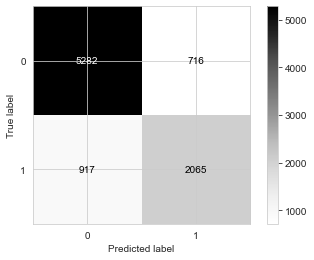

In [22]:
#fitting linear regression
logreg = LogisticRegression()
logreg.fit(X_pca, y_train)


#generating confusion matrix
Y_pred = logreg.predict(X_test_pca)
confusionMatrix = confusion_matrix(y_test, Y_pred)
print(confusionMatrix)
diagram = metrics.ConfusionMatrixDisplay(confusionMatrix,display_labels=None)
diagram.plot(cmap = 'Greys')

In [23]:
print ('Accuracy :', metrics.accuracy_score(y_test, Y_pred) )
print ('F1 score :', metrics.f1_score(y_test, Y_pred) )
print ('Recall   :', metrics.recall_score(y_test, Y_pred) )
print ('Precision:', metrics.precision_score(y_test, Y_pred) )

Accuracy : 0.81815144766147
F1 score : 0.7166406385563076
Recall   : 0.6924882629107981
Precision: 0.7425386551600144


In [24]:
# Parameter Tuning
clf = LogisticRegression(solver = 'lbfgs', random_state = 10)
grid_values = {'penalty': ['l2'],
               'C':[1,10,100,1000,10000],
               'max_iter':[1000000]}
# Using 5 folds cross validation
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, cv = 5 , verbose = 0, scoring = 'accuracy')
grid_clf_acc.fit(X_pca, y_train)

#Predict values based on new parameters
y_pred_acc = grid_clf_acc.predict(X_test_pca)

In [25]:
print('\nThe best hyperparameters:\n', grid_clf_acc.best_params_)


The best hyperparameters:
 {'C': 1, 'max_iter': 1000000, 'penalty': 'l2'}


In [26]:
# New Model Evaluation metrics
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_acc, average = 'micro')))
print('Recall Score : ' + str(recall_score(y_test, y_pred_acc, average = 'micro')))
print('F1 Score : ' + str(f1_score(y_test, y_pred_acc, average = 'micro')))

Accuracy Score : 0.81815144766147
Precision Score : 0.81815144766147
Recall Score : 0.81815144766147
F1 Score : 0.81815144766147


In [27]:
lg_2 = LogisticRegression(solver = 'lbfgs', random_state = 10, C = 1, max_iter = 1000000, penalty = "l2")

# Fit the model
lg_2.fit(X_pca, y_train)

print('Logistic Regression Accuracy: {:.3f}'.format(accuracy_score(y_test, lg_2.predict(X_test_pca))))

Logistic Regression Accuracy: 0.818


# KNeighborsClassifier

[[5799  199]
 [  59 2923]]


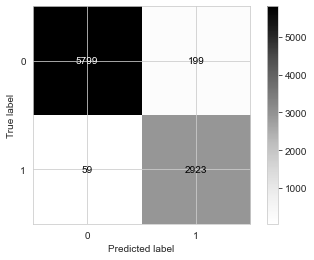

In [28]:
#fitting KNN
KNN = KNeighborsClassifier(n_neighbors=2)
KNN.fit(X_scaled, y_train)


#generating confusion matrix
Y_pred = KNN.predict(X_test_scaled)
confusionMatrix = confusion_matrix(y_test, Y_pred)
print(confusionMatrix)
diagram = metrics.ConfusionMatrixDisplay(confusionMatrix,display_labels=None)
diagram.plot(cmap = 'Greys')

In [29]:
print ('Accuracy :', metrics.accuracy_score(y_test, Y_pred) )
print ('F1 score :', metrics.f1_score(y_test, Y_pred) )
print ('Recall   :', metrics.recall_score(y_test, Y_pred) )
print ('Precision:', metrics.precision_score(y_test, Y_pred) )

Accuracy : 0.9712694877505568
F1 score : 0.9577326343381388
Recall   : 0.9802146210596915
Precision: 0.9362588084561179


# CART

[[5889  109]
 [  68 2914]]


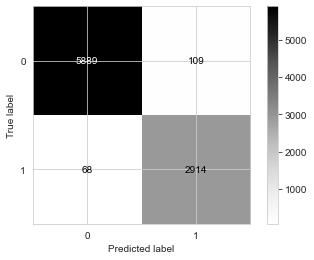

In [30]:
#fitting CART
CART = DecisionTreeClassifier()
CART.fit(X_train, y_train)


#generating confusion matrix
Y_pred = CART.predict(X_test)
confusionMatrix = confusion_matrix(y_test, Y_pred)
print(confusionMatrix)
diagram = metrics.ConfusionMatrixDisplay(confusionMatrix,display_labels=None)
diagram.plot(cmap = 'Greys')

In [31]:
print ('Accuracy :', metrics.accuracy_score(y_test, Y_pred) )
print ('F1 score :', metrics.f1_score(y_test, Y_pred) )
print ('Recall   :', metrics.recall_score(y_test, Y_pred) )
print ('Precision:', metrics.precision_score(y_test, Y_pred) )

Accuracy : 0.9802895322939866
F1 score : 0.9705245628642798
Recall   : 0.97719651240778
Precision: 0.9639431028779358


# Random Forest

[[5952   46]
 [  43 2939]]


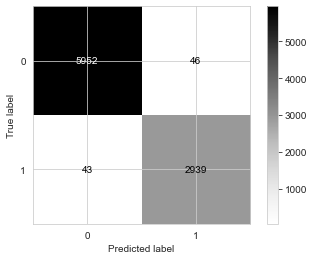

In [32]:
#fitting RF
RF = RandomForestClassifier()
RF.fit(X_train, y_train)


#generating confusion matrix
Y_pred = RF.predict(X_test)
confusionMatrix = confusion_matrix(y_test, Y_pred)
print(confusionMatrix)
diagram = metrics.ConfusionMatrixDisplay(confusionMatrix,display_labels=None)
diagram.plot(cmap = 'Greys')

In [33]:
print ('Accuracy :', metrics.accuracy_score(y_test, Y_pred) )
print ('F1 score :', metrics.f1_score(y_test, Y_pred) )
print ('Recall   :', metrics.recall_score(y_test, Y_pred) )
print ('Precision:', metrics.precision_score(y_test, Y_pred) )

Accuracy : 0.9900890868596882
F1 score : 0.9850846321434557
Recall   : 0.9855801475519785
Precision: 0.9845896147403685


In [34]:
# Feature Importance
rf_coeff_df = pd.DataFrame(X_train.columns)
rf_coeff_df.columns = ['Features']

rf_coeff_df['Coefficient'] = pd.Series(RF.feature_importances_)

rf_coeff_df = rf_coeff_df.sort_values(by = 'Coefficient', ascending = False).round(4).head(20)
rf_coeff_df

,Features,Coefficient
1,app,0.2750
2,device,0.2162
0,ip,0.1606
4,channel,0.1038
11,ip_nextClick,0.0641
3,os,0.0553
8,click_hour,0.0336
9,click_min,0.0283
7,click_day,0.0233
12,ip_app_nextClick,0.0162


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 0.1)

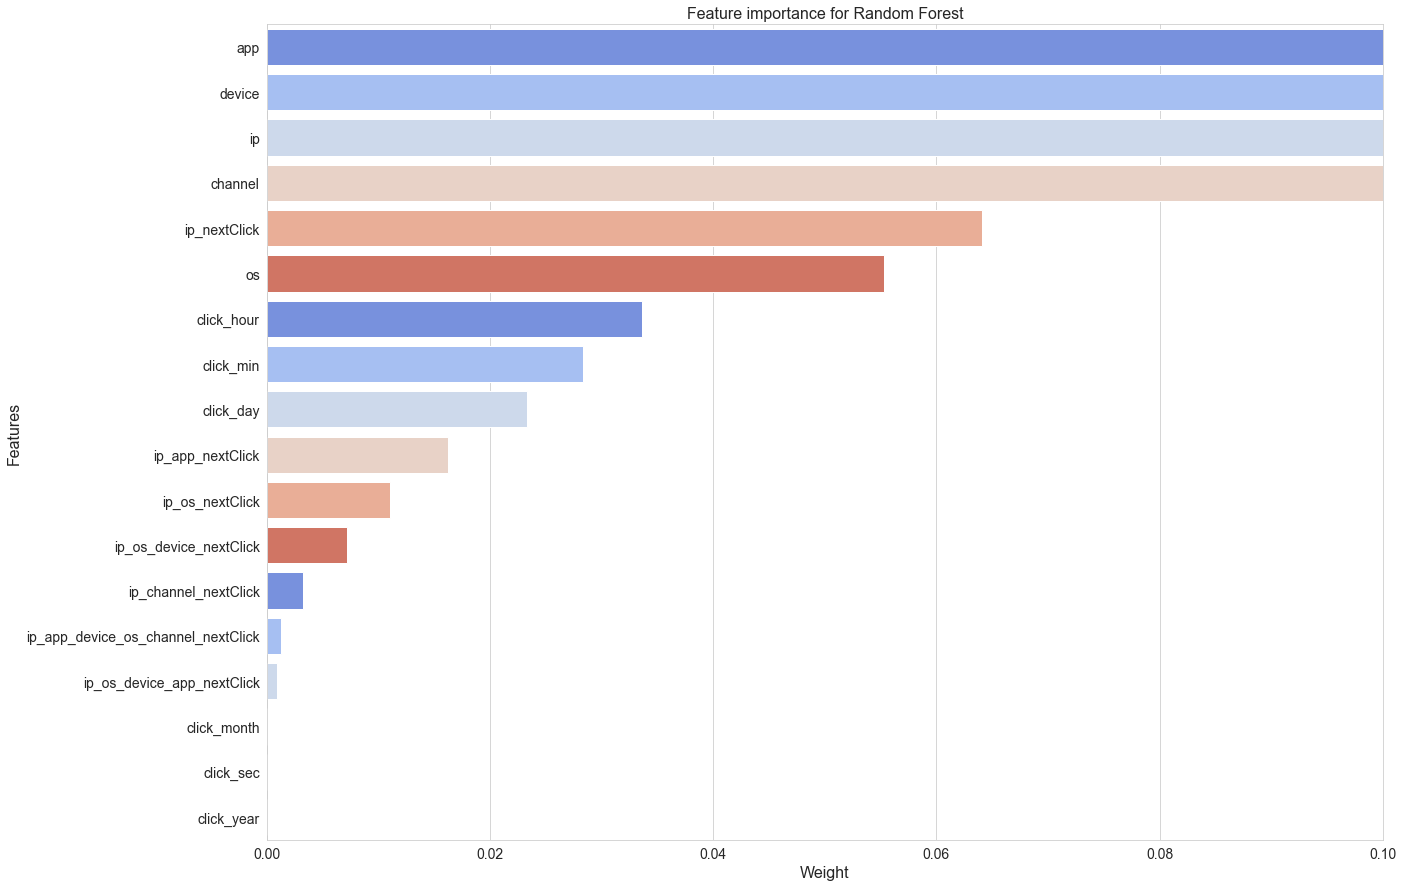

In [35]:
# Set figure size. 
rcParams['figure.figsize'] = (20, 15)

# Make barplot
ax = sns.barplot('Coefficient', 'Features', data = rf_coeff_df,  capsize = 0.5, palette = sns.color_palette('coolwarm'), orient = 'h')

# Set x_label, y_label, plot title name.  
ax.set_xlabel('Weight', fontsize = 16)
ax.set_ylabel('Features', fontsize = 16)
ax.set_title('Feature importance for Random Forest', fontsize = 16)

# Set the fontsize for x axis and y axis. 
ax.tick_params(axis = 'y', labelsize = 14)
ax.tick_params(axis = 'x', labelsize = 14)

# Set limit number for x axis.
plt.xlim(0, 0.1)